# Transfer Learning with tensorflow(Feacture Extraction)

In [1]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-03-14 16:10:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.7MB/s    in 8.1s    

2024-03-14 16:10:25 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

In [3]:
for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
 print(f'There are {len(dirnames)} directories and {len(filenames)}in {dirpath}')

There are 2 directories and 0in 10_food_classes_10_percent
There are 10 directories and 0in 10_food_classes_10_percent/train
There are 0 directories and 75in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75in 10_food_classes_10_percent/train/steak
There are 0 directories and 75in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75in 10_food_classes_10_percent/train/hamburger
There are 10 directories and 0in 10_food_classes_10_percent/test
There are 0 directories and 250in 10_food_classes_10

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='categorical')
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [5]:
import datetime
def create_tensorboard_callback(dir_name,expirement_name):
    log_dir = dir_name + '/' + expirement_name + '/' + datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'saving Tensorboard log files to: {log_dir}')
    return tensorboard_callback

In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes =10):
    feacture_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='feacture_extractor_layer',
                                             input_shape = IMAGE_SHAPE+(3,))
    model = tf.keras.Sequential([
        feacture_extractor_layer,
        layers.Dense(num_classes,activation='softmax',name='output_layer')
    ])

    return model

In [9]:
IMAGE_SHAPE=(224,224)

In [10]:
resnet_model = create_model(resnet_url,
                           num_classes = train_data_10_percent.num_classes)

In [11]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feacture_extractor_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
history_resnet = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data = test_data,
                 callbacks = [create_tensorboard_callback(dir_name = 'tenserflow_hub',
                                                          expirement_name='resnet50V2')])

saving Tensorboard log files to: tenserflow_hub/resnet50V2/20240314161038
Epoch 1/5
24/24 [==============================] - 22s 610ms/step - loss: 1.9682 - accuracy: 0.3480 - val_loss: 1.2216 - val_accuracy: 0.6120
Epoch 2/5
24/24 [==============================] - 12s 527ms/step - loss: 0.9023 - accuracy: 0.7320 - val_loss: 0.8598 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 13s 545ms/step - loss: 0.6183 - accuracy: 0.8280 - val_loss: 0.7632 - val_accuracy: 0.7548
Epoch 4/5
24/24 [==============================] - 11s 484ms/step - loss: 0.4810 - accuracy: 0.8653 - val_loss: 0.7156 - val_accuracy: 0.7688
Epoch 5/5
24/24 [==============================] - 11s 474ms/step - loss: 0.3762 - accuracy: 0.9080 - val_loss: 0.6812 - val_accuracy: 0.7764


In [14]:
import matplotlib.pyplot as plt
def plot_loss_corves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy= history.history['val_accuracy']

  epochs  = range(len(history.history['loss']))

  plt.plot(epochs,loss,label='training_loss')
  plt.plot(epochs,val_loss ,label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')

  plt.figure()
  plt.plot(epochs,accuracy,label='training_accuracy')
  plt.plot(epochs,val_accuracy ,label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')

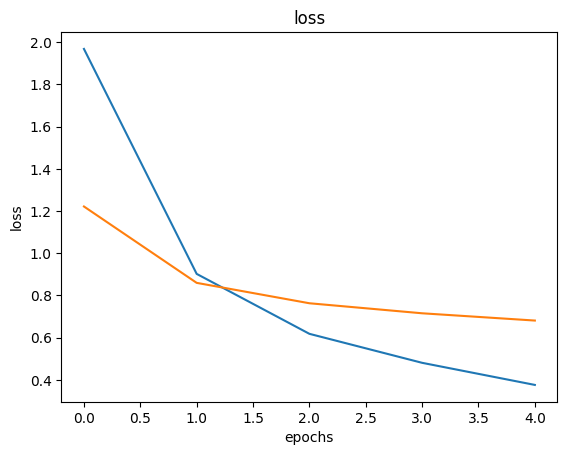

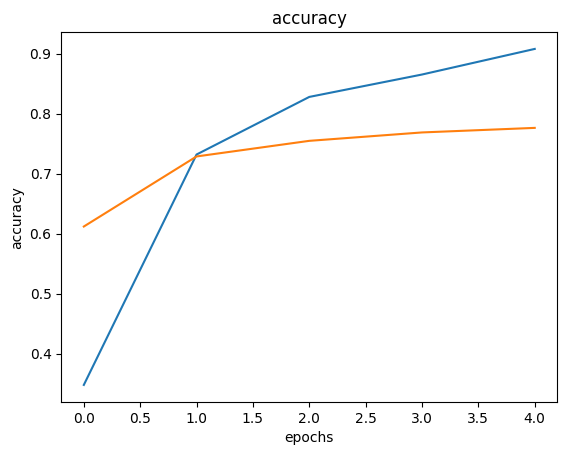

In [15]:
plot_loss_corves(history_resnet)

## Creating and Testing EfficientNetB0 Tensorflow Hub Feacture Extraciton model

In [16]:
efficient_model = create_model(model_url=efficientnet_url,
                               num_classes= train_data_10_percent.num_classes)
efficient_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])
efficientnet_history = efficient_model.fit(train_data_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data = test_data,
                                           validation_steps = len(test_data),
                                           callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                  expirement_name='efficientnetb0')])

saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20240314161220
Epoch 1/5
24/24 [==============================] - 24s 600ms/step - loss: 1.8845 - accuracy: 0.4200 - val_loss: 1.3337 - val_accuracy: 0.7348
Epoch 2/5
24/24 [==============================] - 10s 432ms/step - loss: 1.0889 - accuracy: 0.7533 - val_loss: 0.8896 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 10s 424ms/step - loss: 0.7797 - accuracy: 0.8173 - val_loss: 0.7116 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 10s 424ms/step - loss: 0.6258 - accuracy: 0.8533 - val_loss: 0.6211 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 11s 453ms/step - loss: 0.5288 - accuracy: 0.8800 - val_loss: 0.5652 - val_accuracy: 0.8564


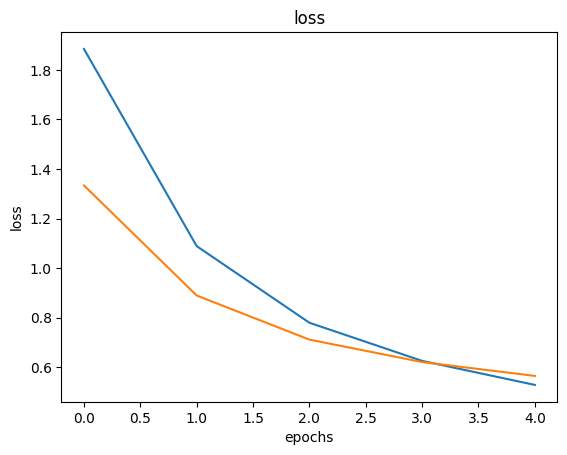

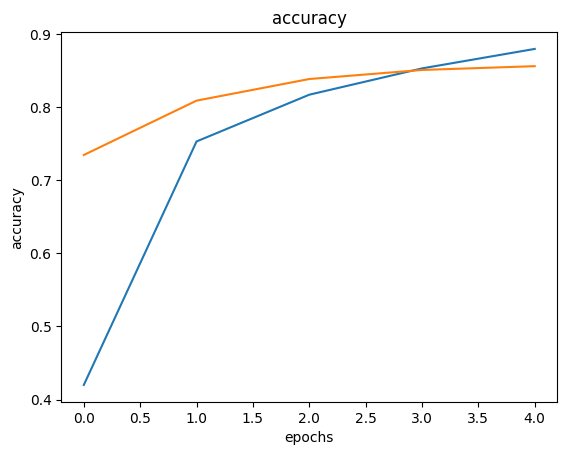

In [17]:
plot_loss_corves(efficientnet_history)